# Analiza zbioru Kandinsky Patterns
### przygotowana przez:  *Mazuryk, Kosiuk, Sawicki*

W swojej pracy będziemy korzystać z danych z wyzwania 1. Skupimy się na następujących aspektach: 
- wyjaśnienie związane z kształtem,
- analiza wektora/przestrzeni reprezentacji,
- analiza wyjaśnień klas sprzecznych i losowych,


## 1. Analiza artykułów

A) **„Sanity Checks for Saliency Maps”** - *Julius Adebayo, Justin Gilmer, Michael Muelly, Ian Goodfellow, Moritz Hardt, Been Kim*

W artykule autorzy skupiają się na przeprowadzeniu dwóch tesów dotyczących sprawdzenia efektywności metod wyjaśnień w klasyfikacji sieci neuronowych:
- The model parameter randomization test 
- The data randomization test

Pierwszy z nich polega na wykorzystaniu metod wyjaśnień przy stopniowym rozregulowaniu modelu. Dzięki temu sprawdzamy jaka jest zależność między wygenerowanym wyjaśnieniem, a faktycznym wytrenowaniem naszego modelu.
Drugi test polega na wymieszaniu etykiet do zdjęć i późniejszym wytrenowaniu modelu. Przy takim przetasowaniu skuteczność modelu jest na poziomie losowego wyboru, więc i wyjaśnienia nie powinny wskazywać na nic znaczącego. 
W przypadku gdy dana metoda nie spełni wyżej wymienionych testów możemy stwierdzić, że nie bazuje ona na wiedzy nauczonego modelu. Bliżej jej wtedy do edge detectora, który nie wymaga ani wytrenowania, ani zbioru danych. Działa wtedy na zasadzie zwykłej funkcji, która za argument bierze obraz, a jej wynikiem są charakterystyczne punkty na obrazie, tym samym nie dając nam wglądu w myślenie modelu.

Autorzy pokazują nam, że czysto wizualne sprawdzenie wyjaśnień może być niewystarczające. Powinniśmy użyć takich testów by określić faktyczną skuteczność tworzonych metod wyjaśnień.

https://arxiv.org/pdf/1810.03292.pdf


B) **"EXPLAINABLE ARTIFICIAL INTELLIGENCE: UNDERSTANDING, VISUALIZING AND INTERPRETING DEEP LEARNING MODELS"** - *Wojciech Samek, Thomas Wiegand, Klaus-Robert Muller*

Artykuł opowiada o interpretowalności modeli przedstawiając dwie metody pozwalające na wyjaśnianie wyników. Pierwszą z nich jest metoda Sensitivity Analysis. Służy ona do analizy jaki wpływ ma zmiana wartości w danym pikselu obrazu na predykcję modelu. Piksele z największą wrażliwością na zmiany są tymi o największym znaczeniu. Metoda korzysta z wyliczenia pochodnych i jej główną zaletą jest fakt, że użycie heatmapy dosyć dobrze wskazuje, które obszary są najważniejsze dla modelu. Niestety analiza nie wyjaśnia, dlaczego konkretne obszary odpowiadają za wykrycie konkretnej klasy, a także potrafi zaklasyfikować elementy obrazu, które w rzeczywistości nie powinny mieć wpływu na klasyfikację, jako znaczące dla modelu. Dodatkowo, heatmapy stworzone za pomocą tej metody są bardziej zaszumione. Drugą metodą jest Layer-Wise Relevance Propagation. Metoda ta korzysta z dekompozycji i ustala jak bardzo dany piksel przyczynia się do danej klasyfikacji. Według autora, metoda ta sprawdza się dużo lepiej niż metoda Sensitive Analysis, a do jej zalet należy to, że metoda realnie pokazuje elementy charakterystyczne dla danej klasy, a nie te, których zmiana wpływa na predykcję modelu.

https://arxiv.org/abs/1708.08296

C) **„Feature Representation In Convolutional Neural Networks”** - *Ben Athiwaratkun, Keegan Kang*

W artykule porównano konwolucyjne sieci neuronowe w roli klasyfikatorów i modele hybrydowe (warstwy konwolucyjne jako feature extractory, klasyfikacja dokonywana Random Forest lub SVM na podstawie wektora reprezentacji). Okazuje się, że takie podejście pozwala uniknąć overfittingu i daje podobne rezultaty do zastosowania dropout'u przy mniejszym koszcie obliczeniowym.

Wady:

porównanie małych (do 5 warstw konwolucyjnych) sieci, brak porównania CNN klasy SOTA
brak optymalizacji hiperparametrów SVM i random forest
nie opisano jak tworzono wektor reprezentacji po warstwie konwolucyjnej
Zalety:

Analiza wektora reprezentacji z różnych warstw sieci
https://arxiv.org/abs/1507.02313

## 2. Wczytanie danych

In [ ]:
!unzip challenge-nr-1.zip;

In [ ]:

! pip install torchinfo captum timm

     |████████████████████████████████| 1.4 MB 7.0 MB/s 
     |████████████████████████████████| 431 kB 49.1 MB/s 


In [ ]:
import torch
import torchvision
import torchinfo
import torchvision.transforms as transforms
import captum
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
import pandas as pd
import json
import torchvision.models as models
from IPython.display import clear_output
from timm.loss import LabelSmoothingCrossEntropy 

torch.set_printoptions(linewidth=120)

In [ ]:
transform = transforms.Compose([
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

    # ImageFloder with root directory and defined transformation methods for batch as well as data augmentation
data = torchvision.datasets.ImageFolder('../content/challenge-nr-1/', transform=transform)

In [ ]:
data

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: ../content/challenge-nr-1/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
len_train_dataset=2500
len_test_dataset=500
data_test, data_train = torch.utils.data.random_split(data, [len_test_dataset, len_train_dataset])
test_dataloader  = torch.utils.data.DataLoader(dataset=data_test, batch_size=32, shuffle=True)
train_dataloader  = torch.utils.data.DataLoader(dataset=data_train, batch_size=32, shuffle=True)

## 3. Budowa modelu

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc=nn.Linear(512, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = resnet18.to(device)
params_to_update = model_ft.parameters()
optimizer = optim.AdamW(params_to_update, lr=0.001, weight_decay=0.25)
criterion = nn.CrossEntropyLoss()
n_epoch = 10



In [ ]:

train_results = []
test_results = []
for epoch in range(n_epoch):
        print('Epoch {}/{}'.format(epoch + 1, n_epoch))
        print('-' * 10)

        model_ft.train()
        train_loss = 0
        train_correct = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            loss.backward()
            optimizer.step()

        model_ft.eval()
        test_loss = 0
        test_correct = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            batch_loss = criterion(outputs, labels).item()
            with torch.no_grad():
                test_loss += batch_loss
                test_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

        test_acc = test_correct / len_test_dataset
        train_acc = train_correct / len_train_dataset
        train_results += [{'loss': train_loss, 'acc': train_acc}]
        test_results += [{'loss': test_loss, 'acc':test_acc}]

Epoch 1/10
----------
Epoch 2/10
----------
Epoch 3/10
----------
Epoch 4/10
----------
Epoch 5/10
----------
Epoch 6/10
----------
Epoch 7/10
----------
Epoch 8/10
----------
Epoch 9/10
----------
Epoch 10/10
----------



## 4. Analiza modelu

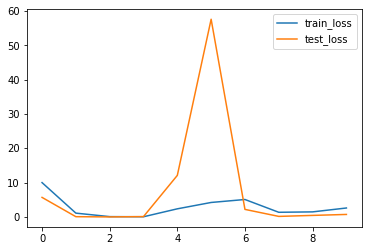

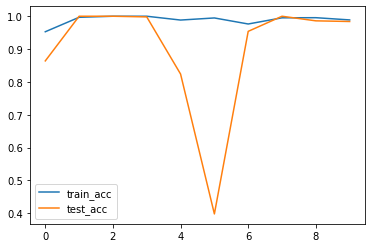

In [ ]:

train_df = pd.DataFrame(train_results)
train_df.columns = ['train_' + col for col in train_df.columns]
test_df = pd.DataFrame(test_results)
test_df.columns = ['test_' + col for col in test_df.columns]

pd.concat([train_df, test_df], axis=1).loc[:,['train_loss', 'test_loss']].plot()
pd.concat([train_df, test_df], axis=1).loc[:,['train_acc', 'test_acc']].plot()

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
@torch.no_grad()
def get_all_preds(model, loader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  all_preds = torch.tensor([]).to(device)
  for batch in loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds


test_loader = torch.utils.data.DataLoader(data_test, batch_size = 32,num_workers=2)
test_preds = get_all_preds(model_ft, test_loader)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_test1 = np.array(data_test)
actual_labels = torch.Tensor(list(data_test1[:,1])).to(device)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

def plot_confusion_matrix(cm, classes):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### *Macierz konfuzji:*

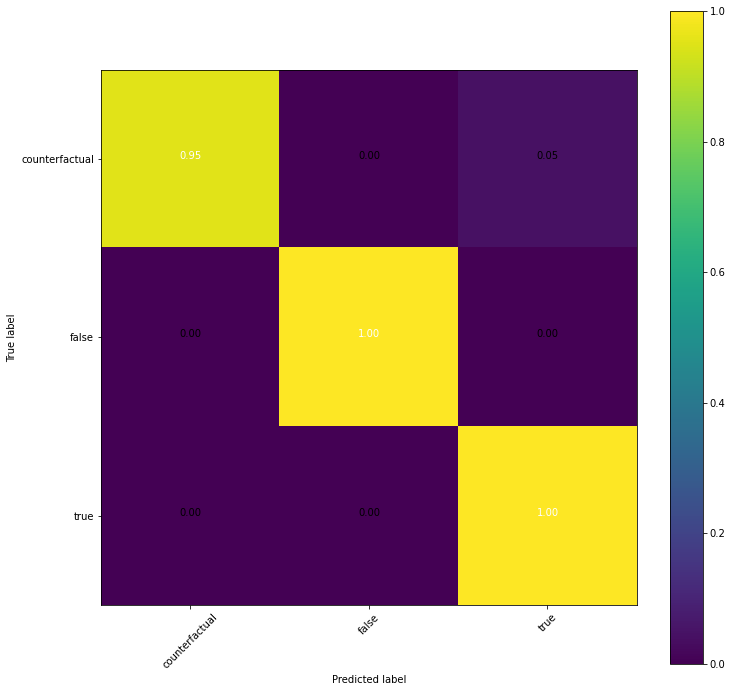

In [ ]:
cm = confusion_matrix(torch.Tensor(list(data_test1[:,1])), test_preds.cpu().argmax(dim=1))
classes = ('counterfactual', 'false', 'true')
plt.figure(figsize = (12,12))
plot_confusion_matrix(cm, classes)

In [ ]:
print("Accuracy:",preds_correct/len_test_dataset)

Accuracy: 0.984


Zapis modelu:

In [ ]:
PATH = './model_ft.pth'
torch.save(model_ft.state_dict(), PATH)

### Wyjaśnienie modelu

In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


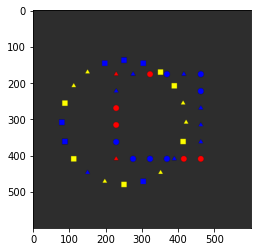

In [ ]:
plt.imshow(data_test1[10][0].permute(1,2,0))

In [ ]:
torch.argmax(test_preds,dim=1)[10]

tensor(2, device='cuda:0')

In [ ]:
actual_labels[10]

tensor(2., device='cuda:0')

### LIME Explanation

In [ ]:
from captum.attr import Lime

In [ ]:
from captum.attr import visualization
from skimage import segmentation

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

def mask(image):
  return segmentation.slic(
    image.permute(1, 2, 0).mean(axis=2), 
    n_segments=800, 
    compactness=0.1, 
    start_label=0,
  )

preprocess = torchvision.transforms.Compose([
   torchvision.transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


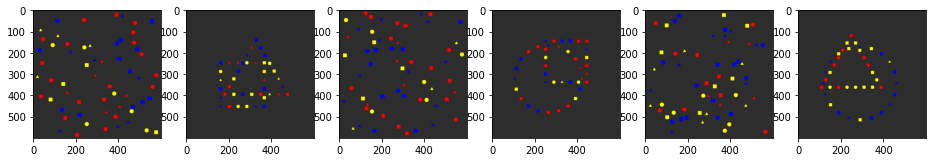

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=[16, 8])
for i in range(6):
  ax[i].imshow(data_test1[i][0].permute(1,2,0))

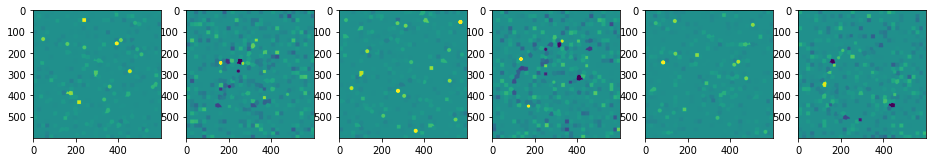

In [ ]:
explainer = Lime(model_ft)

def mask(image):
  return segmentation.slic(
    image.permute(1, 2, 0).mean(axis=2), 
    n_segments=1000, 
    compactness=0.2, 
    start_label=0,
  )

def attr(i):
  return explainer.attribute(
    preprocess(data_test1[i][0]).unsqueeze(0).to(device), 
    target=torch.argmax(test_preds,dim=1)[i], 
    n_samples=500, 
    feature_mask=torch.as_tensor(mask(data_test1[i][0])).to(device),
    show_progress=False
  )

fig, ax = plt.subplots(1, 6, figsize=[16, 8])
for i in range(6):
  ax[i].imshow(attr(i)[0].permute(1,2,0).cpu().mean(axis=2), vmin=-1, vmax=1)


### SHAP explanation

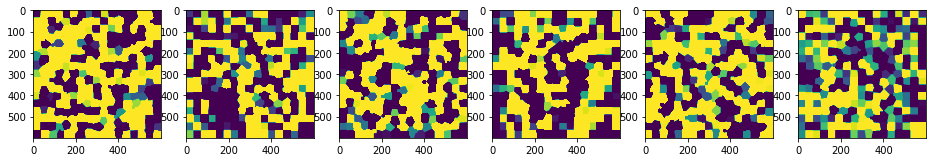

In [ ]:
from captum.attr import KernelShap
exp_ks = KernelShap(model_ft)

def mask(image):
  return segmentation.slic(
    image.permute(1, 2, 0).mean(axis=2), 
    n_segments=300, 
    compactness=0.1, 
    start_label=0,
  )


def attr_ks(i):
  return exp_ks.attribute(
    preprocess(data_test1[i][0]).unsqueeze(0).to(device), 
    target=torch.argmax(test_preds,dim=1)[i], 
    n_samples=400, 
    feature_mask=torch.as_tensor(mask(data_test1[i][0])).to(device),
    show_progress=False
  )
fig, ax = plt.subplots(1, 6, figsize=[16, 8])
for i in range(6):
  ax[i].imshow(attr_ks(i)[0].permute(1,2,0).cpu().mean(axis=2), vmin=-1, vmax=1)